# MSE model of ascent fraction, including entrainment of dry-air

Anna Mackie, 2024

This script demonstrates and tests the instability index. It produces the following plots:
-  Fig S1: vertical velocity pdfs of the different patches in the control simulation
- Fig S2: Compare histograms and profiles with and without adjustment
- Fig 1: ascent fraction as calculated with vertical velocity and entrainment-adjusted instability index
- Fig S3: As Fig 1 but with WTG-test added in
- Fig 2: demonstration of the instability index before and after entrainment adjustement

In [2]:
import sys
import pathlib
import platform
venv_path = '~/nb-venvs/metpy_venv'
sys.path.append(str(pathlib.Path(f'{venv_path}/lib/python{platform.python_version_tuple()[0]}.{platform.python_version_tuple()[1]}/site-packages/').expanduser()))

import metpy
print(metpy.__file__)

/opt/jaspy/lib/python3.11/site-packages/metpy/__init__.py


In [9]:
import numpy as np
import numpy.ma as ma
import cf
import matplotlib.pyplot as plt
from matplotlib import colors
import xarray as xr
from mpl_toolkits.basemap import Basemap
import matplotlib as mpl
import cartopy.crs as ccrs
from copy import copy
import glob
from scipy import stats
from scipy.optimize import minimize
from scipy.optimize import dual_annealing
from scipy.ndimage import gaussian_filter
import metpy.calc as mc
from metpy.units import units
import sys
#sys.path.append('../')
import functions as fns
import regionmask
import matplotlib.gridspec as gridspec


plt.rcParams.update({'font.size': 10})

lets = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)', 'g)', 'h)', 'i)', 'j)', 'k)', 'l)']    

sst_inc = ['-4', '-3', '-2', '-1','+1', '+2', '+3', '+4']
sst_dig = [-4, -3, -2, -1, 1, 2, 3, 4]
patches = ['100E', '140E', '180E', '220E']
cols = ['steelblue', 'deepskyblue', 'lightskyblue', 'powderblue','lightsalmon', 'darksalmon', 'tomato', 'red']#'
patch_cols = ['red', 'green', 'orange','blue']
markers = ['o', 'd']
lines = ['-', '--']

def proportion_overcome_conv_threshold(hsfc, hsat500, weights, landmask):
    """ proportion of domain ascending using instability
    index, including area weighting
    """
    lon, month = hsfc.lon, hsfc.month
    weights = weights.where(landmask.notnull()==False)
    if np.ndim(hsfc) ==3:
        weights_3Darray = (weights * xr.DataArray(np.ones(len(month)), dims=("month"))).T * xr.DataArray(np.ones(len(lon)), dims=("lon"))
    else:
        weights_3Darray = (weights * xr.DataArray(np.ones(len(lon)), dims=("lon")))
    instab_index = hsfc - hsat500
    return weights_3Darray.where(instab_index > 0).sum() / weights_3Darray.sum()

def calc_ascent_frac(wap500, weights, landmask):
    """ proportion of domain ascending using vertical velocity
    at 500 hPa, including area weighting
    """
    lon, month = wap500.lon, wap500.month
    weights = weights.where(landmask.notnull()==False)
    if np.ndim(wap500) ==3:
        weights_3Darray = (weights * xr.DataArray(np.ones(len(month)), dims=("month"))).T * xr.DataArray(np.ones(len(lon)), dims=("lon"))
    else:
        weights_3Darray = (weights * xr.DataArray(np.ones(len(lon)), dims=("lon")))
                           
    return weights_3Darray.where(wap500 < 0).sum() / weights_3Darray.sum()

def calc_prop(arr, weights, landmask):
    lon, month = arr.lon, arr.month
    weights = weights.where(landmask.notnull()==False)
    if np.ndim(arr) ==3:
        weights_3Darray = (weights * xr.DataArray(np.ones(len(month)), dims=("month"))).T * xr.DataArray(np.ones(len(lon)), dims=("lon"))
    else:
        weights_3Darray = (weights * xr.DataArray(np.ones(len(lon)), dims=("lon")))
    return float(weights_3Darray.where(arr.notnull()==True).sum() / weights_3Darray.sum())

def createA(dig, b, weights):
    """
    creates the normalised area pdf
    """
    num = [weights.where(dig == i).sum() for i in range(1,b)]
    A_bin = num/np.sum(num) # normalise
    return A_bin

# Constants, control, preamble

In [4]:
# constants
l = 20
g = metpy.constants.earth_gravity
cp = metpy.constants.dry_air_spec_heat_press
Lv = metpy.constants.water_heat_vaporization
Rv = metpy.constants.water_gas_constant
Md = metpy.constants.dry_air_molecular_weight
R0 = metpy.constants.dry_air_gas_constant
sst_change = [-4,-3,-2,-1,1,2,3,4]
no_patches = len(patches)
no_temps = len(sst_dig)
deltaT_placeholder = 1



In [5]:
# make landmask and latitude weighting from control
ds = xr.open_dataset('data/control_2d.nc')
ds3d = xr.open_dataset('data/control_3d.nc')

lat = ds.lat.sel(lat = slice(-l,l))

#define land mask
landmask = regionmask.defined_regions.natural_earth_v5_0_0.land_110.mask(ds.lon, lat)
weights = np.cos(np.deg2rad(lat))

SST = ds.ts.sel(lat = slice(-l, l)).where(landmask.notnull()==False)

In [6]:
# define patch extent from delta SST from +4K experiments. 
for k in range(4):
        patch = patches[k]
        ds1 = xr.open_dataset('data/'+ patch +'_0N_+4K_2d.nc')
        SST1 = ds1.ts.sel(lat = slice(-l, l)).where(landmask.notnull()==False)
    
        if k==0:
            patch_extents = (SST1 - SST).where((SST1 - SST) > 0.4)
            
        else:
            patch_extent1 = (SST1 - SST).where((SST1 - SST) > 0.4)
            patch_extents = xr.concat([patch_extents, patch_extent1], "newdim")

In [7]:
#control
zg_ctrl = ds3d.zg.sel(lat = slice(-l, l)).where(landmask.notnull()==False) *units.m
ta_ctrl = ds3d.ta.sel(lat = slice(-l, l)).where(landmask.notnull()==False) *units.K
q_ctrl = ds3d.hus.sel(lat = slice(-l, l)).where(landmask.notnull()==False)*units.kilogram / units.kilogram
rh_ctrl = ds3d.hur.sel(lat = slice(-l, l)).where(landmask.notnull()==False)
pfull_ctrl = ds3d.pfull.sel(lat = slice(-l, l)).where(landmask.notnull()==False) *units.Pa
ps_ctrl = ds.ps.sel(lat = slice(-l,l)).where(landmask.notnull()==False) * units.Pa
ts_ctrl = ds.ts.sel(lat = slice(-l,l)).where(landmask.notnull()==False) * units.K
tas_ctrl = ds.tas.sel(lat = slice(-l,l)).where(landmask.notnull()==False) * units.K
dew2_ctrl = ds.dew2.sel(lat = slice(-l,l)).where(landmask.notnull()==False)* units.K
pr_ctrl = ds.pr.sel(lat = slice(-l,l)).where(landmask.notnull()==False)
q2m_ctrl = mc.specific_humidity_from_dewpoint(ps_ctrl, dew2_ctrl)
rh2m_ctrl = mc.relative_humidity_from_dewpoint(tas_ctrl, dew2_ctrl)

p_in_hPa = ta_ctrl.plev/100

swcre_ctrl = ds.rsutcs.sel(lat = slice(-l,l)).where(landmask.notnull()==False) - ds.rsut.sel(lat = slice(-l,l)).where(landmask.notnull()==False)
lwcre_ctrl = ds.rlutcs.sel(lat = slice(-l,l)).where(landmask.notnull()==False) - ds.rlut.sel(lat = slice(-l,l)).where(landmask.notnull()==False)
netcre_ctrl = swcre_ctrl + lwcre_ctrl

#MSE
h_ctrl = mc.moist_static_energy(zg_ctrl, ta_ctrl, q_ctrl)
hsfc_ctrl = mc.moist_static_energy(2*units.m, tas_ctrl, q2m_ctrl)

#MSE*
sat_mixing_ratio_ctrl = mc.saturation_mixing_ratio(pfull_ctrl, ta_ctrl)
sat_spec_hum_ctrl = mc.specific_humidity_from_mixing_ratio(sat_mixing_ratio_ctrl)
hsat_ctrl = mc.moist_static_energy(zg_ctrl, ta_ctrl, sat_spec_hum_ctrl)

hsat500_ctrl = hsat_ctrl.sel(plev = 50000.)
instability_ctrl = (hsfc_ctrl - hsat500_ctrl).where(landmask.notnull()==False)

wap_ctrl = ds3d.wap.sel(lat = slice(-l, l)) * units.Pa /units.second
wap500_ctrl = wap_ctrl.sel(plev = 50000.).where(landmask.notnull()==False)

alpha_up_ctrl = calc_ascent_frac(wap500_ctrl, weights, landmask)
w_up_ctrl = wap500_ctrl.where(wap500_ctrl <0).weighted(weights).mean()

uas_ctrl = ds.uas.sel(lat = slice(-l, l)).where(landmask.notnull()==False) *units.m/units.second
vas_ctrl = ds.vas.sel(lat = slice(-l, l)).where(landmask.notnull()==False) *units.m/units.second
wind_div_ctrl = mc.divergence(uas_ctrl, vas_ctrl)

vdotgradq_ctrl = mc.geospatial_gradient(q2m_ctrl)[0]*uas_ctrl + mc.geospatial_gradient(q2m_ctrl)[1]*vas_ctrl

lat, lon = ts_ctrl.lat, ts_ctrl.lon
months = ts_ctrl.month

## Fig. S1: Vertical velocity pdfs in control simulation

no of wap500 bins:  164


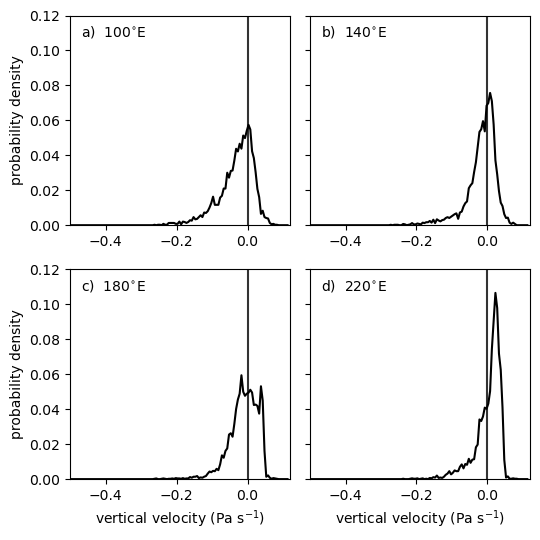

In [11]:
plt.rcParams.update({'font.size': 10})
patch_title = [' 100$^{\circ}$E',  ' 140$^{\circ}$E',  ' 180$^{\circ}$E',  ' 220$^{\circ}$E']

pl = 0.12 # pos limit
nlim= -0.7 # neg limit
bs = 0.005# bin size
bins = np.arange(nlim, pl, bs) #creates bins
b = len(bins)
print('no of wap500 bins: ', b)
mnbin = [np.mean([bins[i-1], bins[i]]) for i in range(1,b)]

fig = plt.figure()
ax1 = plt.subplot2grid((2, 2), (0, 0))
ax2 = plt.subplot2grid((2, 2), (0, 1))
ax3 = plt.subplot2grid((2, 2), (1, 0))
ax4 = plt.subplot2grid((2, 2), (1, 1))

axes = [ax1,ax2,ax3,ax4]

for k in range(4):
    patch = patches[k]
    patch_ex =  patch_extents[k]

    axes[k].plot([0,0],[0,0.12], 'k-', alpha = 0.8)
    wap500_ctrl_patch = wap500_ctrl.where(patch_ex.notnull()==True)
    dig_patch_ctrl = xr.apply_ufunc(np.digitize, np.asarray(wap500_ctrl_patch), bins)* units.dimensionless
    dig_patch_ctrl = xr.DataArray(dig_patch_ctrl, dims=("month", 'lat', 'lon'), coords = (months, lat, lon))
    A_patch_ctrl = np.asarray(createA(dig_patch_ctrl, b, weights))
    axes[k].plot(mnbin, A_patch_ctrl, '-', color = 'k')
    axes[k].text(0.05, 0.9, lets[k] + ' ' + patch_title[k], transform=axes[k].transAxes)
#axes[0].legend(ncol = 2,columnspacing=0.2, frameon = False, loc = [0.1, 0.4])
plt.setp(axes, xlim= [-0.5, 0.12], ylim = [0, 0.12])
plt.setp(axes[2:],  xlabel = 'vertical velocity (Pa$~$s$^{-1}$)')
plt.setp([axes[1], axes[3]], yticklabels = '')
ax1.set_ylabel('probability density')
ax3.set_ylabel('probability density')
fig.subplots_adjust(wspace = 0.1, hspace = 0.1)
fig.set_size_inches(5.5,5.5)
fig.tight_layout()
fig.savefig('newplots/SIFig1.png',dpi = 300, bbox_inches = 'tight')

## SI Fig2: Compare histograms and profiles with and without adjustment 
Joint histogram of vertical velocity and instability index for unadjusted (top, left) and entrainment-adjusted (bottom, left). Right-hand plots compare points which are correctly identified as ascending and those which are incorrectly indentified by the instability index.

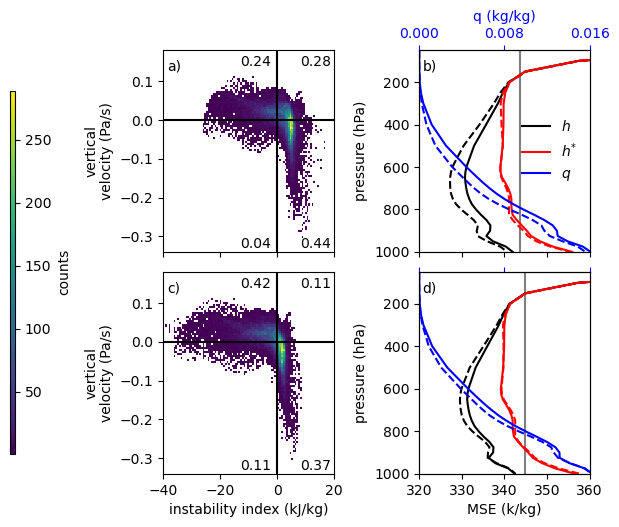

In [12]:
plt.rcParams.update({'font.size': 10})
adjustment_ctrl = np.load('entrainment_adjustments/adjustment_ctrl.npy')
adjustment_ctrl = xr.DataArray(adjustment_ctrl, dims=("month", "lat", "lon"), coords = (months, lat, lon))*units.joule / units.kilogram
ehat = 0.17746965 # taken from 'calc_entrain_adjust.ipynb'

#need to adjust landmask, as some coastal gridpoints have adjustment_ctrl = NaN as they don't have values for 1000hPa
landmask = regionmask.defined_regions.natural_earth_v5_0_0.land_110.mask(ds.lon, lat)
landmask = xr.ones_like(wap500_ctrl).where(landmask.notnull()==False).where(adjustment_ctrl.notnull()==True)
landmask = xr.zeros_like(landmask).where(landmask !=1)

hsfc_ctrl_adjusted = (hsfc_ctrl  - ehat*adjustment_ctrl).where(landmask.notnull()==False)
instability_ctrl_adjusted = (hsfc_ctrl_adjusted -hsat500_ctrl).where(landmask.notnull()==False)
wap500_ctrl = wap500_ctrl.where(landmask.notnull()==False)
instability_ctrl = instability_ctrl.where(landmask.notnull()==False)

fig = plt.figure()
ax0 = plt.subplot2grid((2, 2), (0, 0))
ax1 = plt.subplot2grid((2, 2), (0, 1))
ax2 = plt.subplot2grid((2, 2), (1, 0))
ax3 = plt.subplot2grid((2, 2), (1, 1))
#lim for histos
ylim = [-0.34, 0.18]
xlim = [-40, 20]

#test positions
px1 = 0.8
py1 = 0.02
px2 = 0.45
py2 = 0.92

# ------top row: without entrainment adjustment ----------#
# 2D histogram of vertical velocity and instability index
x, y = np.asarray(instability_ctrl).flatten()[~np.isnan(np.asarray(instability_ctrl).flatten())], np.asarray(wap500_ctrl).flatten()[~np.isnan(np.asarray(wap500_ctrl).flatten())]
cs = ax0.hist2d(x,y,bins = 100, range = [xlim, ylim],cmin = 1, cmax = 300)

for i in [0]:
    ax0.plot([0,0], ylim, 'k-')
    ax0.plot(xlim, [0,0], 'k-')

plt.setp(ax0, xlim = xlim, ylim = ylim)

#add in proportions in each quadrant
ax0.text(px1, py1, str(round(calc_prop(instability_ctrl.where(instability_ctrl>0).where(wap500_ctrl <0), weights,landmask),2)), transform=ax0.transAxes, color = 'k')
ax0.text(px1, py2, str(round(calc_prop(instability_ctrl.where(instability_ctrl>0).where(wap500_ctrl >0), weights,landmask),2)), transform=ax0.transAxes, color = 'k')
ax0.text(px2, py1, str(round(calc_prop(instability_ctrl.where(instability_ctrl<0).where(wap500_ctrl <0), weights,landmask),2)), transform=ax0.transAxes, color = 'k')
ax0.text(px2, py2, str(round(calc_prop(instability_ctrl.where(instability_ctrl<0).where(wap500_ctrl >0), weights,landmask),2)), transform=ax0.transAxes, color = 'k')

ax0.set_ylabel('vertical\nvelocity (Pa/s)')
ax0.set_xticklabels('')
ax0.text(0.02, 0.9, lets[0], transform=ax0.transAxes)

# MSE and q profiles - right hand plots
ax1.plot([hsfc_ctrl.where(instability_ctrl > 0).weighted(weights).mean(), hsfc_ctrl.where(instability_ctrl > 0).weighted(weights).mean()], [1000, 50], 'k-', alpha = 0.5)# line up from surface mse
ax1.plot(h_ctrl.where(instability_ctrl>0).where(wap500_ctrl>0).weighted(weights).mean(dim =('lat', 'lon', 'month')), p_in_hPa, '--', color = 'k')
l1 = ax1.plot(h_ctrl.where(instability_ctrl>0).where(wap500_ctrl<0).weighted(weights).mean(dim =('lat', 'lon', 'month')), p_in_hPa, '-', color = 'k', label = '$h$')
ax1.plot(hsat_ctrl.where(instability_ctrl>0).where(wap500_ctrl>0).weighted(weights).mean(dim =('lat', 'lon', 'month')), p_in_hPa, '--', color = 'r')
l2 = ax1.plot(hsat_ctrl.where(instability_ctrl>0).where(wap500_ctrl<0).weighted(weights).mean(dim =('lat', 'lon', 'month')), p_in_hPa, '-', color = 'r', label= '$h^{*}$')
ax1.text(0.02, 0.9, lets[1], transform=ax1.transAxes)
ax1.set_xticklabels('')

ax1a = ax1.twiny()
ax1a.plot(q_ctrl.where(instability_ctrl>0).where(wap500_ctrl>0).weighted(weights).mean(dim =('lat', 'lon', 'month')), p_in_hPa, '--', color = 'b')
l3 = ax1a.plot(q_ctrl.where(instability_ctrl>0).where(wap500_ctrl<0).weighted(weights).mean(dim =('lat', 'lon', 'month')), p_in_hPa,'-', color = 'b', label = '$q$')
ax1a.set_ylabel('pressure (hPa)')
ax1a.set_xlabel('q (kg/kg)')
ax1a.set_xlim([0,0.016])
ax1a.tick_params(axis='x', colors='b')
ax1a.xaxis.label.set_color('b')

#---------bottom row: with entrainment adjustment--------------#
x,y = np.asarray(instability_ctrl_adjusted).flatten()[~np.isnan(np.asarray(instability_ctrl_adjusted).flatten())], np.asarray(wap500_ctrl).flatten()[~np.isnan(np.asarray(wap500_ctrl).flatten())]
cs1 = ax2.hist2d(x,y, bins = 100, range = [xlim, ylim], cmin = 1, cmax = 300)

plt.colorbar(cs[3], ax = ax0, label = 'counts', cax = ax0.inset_axes([-0.9, -1, 0.03, 1.8]))

for i in [0]:
    ax2.plot([0,0], ylim, 'k-')
    ax2.plot(xlim, [0,0], 'k-')

plt.setp(ax2, xlim = xlim, ylim = ylim)
#add stats
ax2.text(px1, py1, str(round(calc_prop(instability_ctrl_adjusted.where(instability_ctrl_adjusted>0).where(wap500_ctrl <0), weights,landmask),2)), transform=ax2.transAxes, color = 'k')
ax2.text(px1, py2, str(round(calc_prop(instability_ctrl_adjusted.where(instability_ctrl_adjusted>0).where(wap500_ctrl >0), weights,landmask),2)), transform=ax2.transAxes, color = 'k')
ax2.text(px2, py1, str(round(calc_prop(instability_ctrl_adjusted.where(instability_ctrl_adjusted<0).where(wap500_ctrl <0), weights,landmask),2)), transform=ax2.transAxes, color = 'k')
ax2.text(px2, py2, str(round(calc_prop(instability_ctrl_adjusted.where(instability_ctrl_adjusted<0).where(wap500_ctrl >0), weights,landmask),2)), transform=ax2.transAxes, color = 'k')

ax2.set_xlabel('instability index (kJ/kg)')
ax2.set_ylabel('vertical\nvelocity (Pa/s)')
ax2.text(0.02, 0.9, lets[2], transform=ax2.transAxes)

# MSE and q profiles - right hand plot
ax3.plot([hsfc_ctrl.where(instability_ctrl_adjusted > 0).weighted(weights).mean(), hsfc_ctrl.where(instability_ctrl_adjusted > 0).weighted(weights).mean()], [1000, 50], 'k-', alpha = 0.5)# line up from surface mse
ax3.plot(h_ctrl.where(instability_ctrl_adjusted>0).where(wap500_ctrl>0).weighted(weights).mean(dim =('lat', 'lon', 'month')), p_in_hPa, '--', color = 'k')
l1 = ax3.plot(h_ctrl.where(instability_ctrl_adjusted>0).where(wap500_ctrl<0).weighted(weights).mean(dim =('lat', 'lon', 'month')), p_in_hPa, '-', color = 'k', label = '$h$')
ax3.plot(hsat_ctrl.where(instability_ctrl_adjusted>0).where(wap500_ctrl>0).weighted(weights).mean(dim =('lat', 'lon', 'month')), p_in_hPa, '--', color = 'r')
l2 = ax3.plot(hsat_ctrl.where(instability_ctrl_adjusted>0).where(wap500_ctrl<0).weighted(weights).mean(dim =('lat', 'lon', 'month')), p_in_hPa, '-', color = 'r', label= '$h^{*}$')
ax3.text(0.02, 0.9, lets[3], transform=ax3.transAxes)
ax3.set_xlabel('MSE (k/kg)')

ax3a = ax3.twiny()
ax3a.plot(q_ctrl.where(instability_ctrl_adjusted>0).where(wap500_ctrl>0).weighted(weights).mean(dim =('lat', 'lon', 'month')), p_in_hPa, '--', color = 'b')
l3 = ax3a.plot(q_ctrl.where(instability_ctrl_adjusted>0).where(wap500_ctrl<0).weighted(weights).mean(dim =('lat', 'lon', 'month')), p_in_hPa,'-', color = 'b', label = '$q$')
ax3a.tick_params(axis='x', colors='b')
ax3a.set_xticklabels('')
ax3a.set_xlim([0,0.016])


plt.setp([ax1, ax3], xlim = [320, 360], xticks = [320, 330, 340, 350, 360], ylabel = 'pressure (hPa)')
plt.setp([ax1a, ax3a], xlim = [0,0.016], xticks = [0,  0.008,  0.016])

#legend
lns = l1+l2+l3
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, frameon = False)#, loc=[1.2, 0.3])

plt.setp([ax1, ax1a,ax3, ax3a], ylim = [1000, 50])# ,  xlim = [250, 300])
plt.subplots_adjust(wspace = 0.5, hspace = 0.1)
fig.set_size_inches(5.5,5.5)
fig.savefig('newplots/SIFig2.png', bbox_inches = 'tight', dpi = 300)

## Fig 1 and Fig S3: ascent fraction as calculated with vertical velocity and entrainment-adjusted instability index

Fig S3 is the same but with the WTG-test line added: Estimate the perturbation simulation $h^*_{500}$ by using the control $h^*_{500}$ and a tropical-mean difference between the perturbation $h^*_{500}$ and the control $h^*_{500}$. ie this applies the same  $\Delta h^*_{500}$ over the whole domain to see the effect of this 'equal increase' $h^*_{500}$

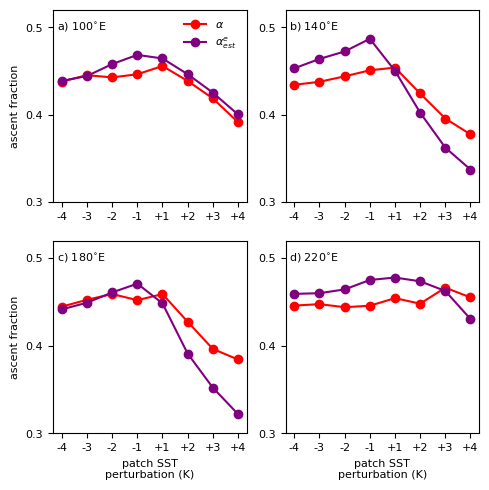

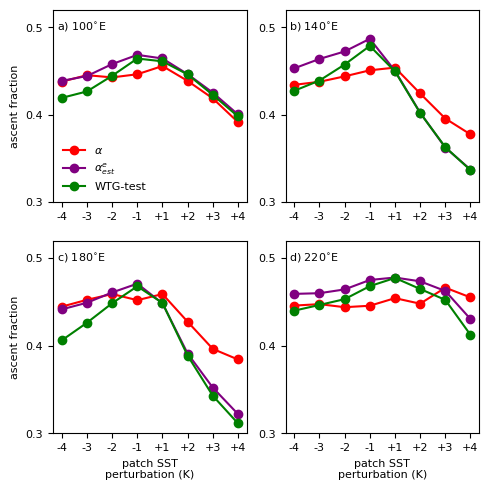

In [17]:
plt.rcParams.update({'font.size': 8})
adjustment_ctrl = np.load('entrainment_adjustments/adjustment_ctrl.npy')
adjustment_ctrl = xr.DataArray(adjustment_ctrl, dims=("month", "lat", "lon"), coords = (months, lat, lon))*units.joule / units.kilogram
ehat = 0.17746965 # taken from 'calc_entrain_adjust.ipynb'

#need to adjust landmask, as some coastal gridpoints have adjustment_ctrl = NaN as they don't have values for 1000hPa
landmask = regionmask.defined_regions.natural_earth_v5_0_0.land_110.mask(ds.lon, lat)
landmask = xr.ones_like(wap500_ctrl).where(landmask.notnull()==False).where(adjustment_ctrl.notnull()==True)
landmask = xr.zeros_like(landmask).where(landmask !=1)

hsfc_ctrl_adjusted = (hsfc_ctrl  - ehat*adjustment_ctrl).where(landmask.notnull()==False)
instability_ctrl_adjusted = (hsfc_ctrl_adjusted -hsat500_ctrl).where(landmask.notnull()==False)
wap500_ctrl = wap500_ctrl.where(landmask.notnull()==False)
instability_ctrl = instability_ctrl.where(landmask.notnull()==False)

# Figure 1
fig1  = plt.figure()
a6 = plt.subplot2grid((2, 2), (0, 0))
a6.text(0.02, 0.9, lets[0] + ' 100$^{\circ}$E', transform=a6.transAxes)
a7 = plt.subplot2grid((2, 2), (0, 1))
a7.text(0.02, 0.9, lets[1]+ ' 140$^{\circ}$E', transform=a7.transAxes)
a8 = plt.subplot2grid((2, 2), (1, 0))
a8.text(0.02, 0.9, lets[2]+ ' 180$^{\circ}$E', transform=a8.transAxes)
a9 = plt.subplot2grid((2, 2), (1, 1))
a9.text(0.02, 0.9, lets[3] + ' 220$^{\circ}$E', transform=a9.transAxes)

ax1 = [a6,a7,a8,a9]

pert_adjustment_array, alpha_up_array = np.empty((4,8)), np.empty((4,8))
hsat500_WTG_array = np.empty((4,8)) # array for testing the WTG approx
for k in range(4):
    patch = patches[k]
    patch_ex =  patch_extents[k]
    for j in range(len(sst_inc)):
        delta_sst = sst_inc[j]
        ds1_3d = xr.open_dataset('data/' + patch +'_0N_' + delta_sst + 'K_3d.nc')
        ds1 = xr.open_dataset('data/' + patch +'_0N_' + delta_sst + 'K_2d.nc')

        wap = ds1_3d.wap.sel(lat = slice(-l,l)).where(landmask.notnull()==False)
        wap500 =wap.sel(plev = 50000.) * units.Pa /units.second
              
        zg = ds1_3d.zg.sel(lat = slice(-l, l)).where(landmask.notnull()==False) *units.m
        ta = ds1_3d.ta.sel(lat = slice(-l, l)).where(landmask.notnull()==False) *units.K
        q = ds1_3d.hus.sel(lat = slice(-l, l)).where(landmask.notnull()==False)*units.kilogram / units.kilogram
        
        pfull = ds1_3d.pfull.sel(lat = slice(-l, l)) *units.Pa
        ps = ds1.ps.sel(lat = slice(-l,l)).where(landmask.notnull()==False) * units.Pa
        ts = ds1.ts.sel(lat = slice(-l,l)).where(landmask.notnull()==False) * units.K
        tas = ds1.tas.sel(lat = slice(-l,l)) * units.K
        
        dew2 = ds1.dew2.sel(lat = slice(-l,l)).where(landmask.notnull()==False)* units.K
        q2m = mc.specific_humidity_from_dewpoint(ps, dew2)
        rh2m = mc.relative_humidity_from_dewpoint(tas, dew2)
        
        #MSE
        h = mc.moist_static_energy(zg, ta, q)
        h500 = h.sel(plev=50000.)
        hsfc = mc.moist_static_energy(2*units.m, tas, q2m)
        
        #MSE*
        sat_mixing_ratio = mc.saturation_mixing_ratio(pfull, ta)
        sat_spec_hum = mc.specific_humidity_from_mixing_ratio(sat_mixing_ratio)
        sat_spec_hum_sfc = mc.specific_humidity_from_mixing_ratio(mc.saturation_mixing_ratio(ps, tas)) # 2m saturation specific humidity via saturation mixing ratio
        hsat = mc.moist_static_energy(zg, ta, sat_spec_hum)
        hsat500 = hsat.sel(plev = 50000.)#sel(plev = slice(30000., 60000.)).weighted(weights).mean(dim = ('plev'))

        hsfc_adjusted_with_ctrl =  hsfc -ehat*adjustment_ctrl        

        adjustment = np.load('entrainment_adjustments/adjustment'+ patch +'_0N_' + delta_sst + 'K.npy')
        adjustment = adjustment *units.joule / units.kilogram
        
        hsfc_adjusted_with_perturbation =  hsfc -ehat*adjustment 

        #WTG-test
        hsat500_WTG= hsat500_ctrl + (hsat500 - hsat500_ctrl).weighted(weights).mean() 
        hsat500_WTG_array[k,j] = proportion_overcome_conv_threshold(hsfc_adjusted_with_perturbation, hsat500_WTG, weights, landmask)

        pert_adjustment_array[k,j] = proportion_overcome_conv_threshold(hsfc_adjusted_with_perturbation, hsat500, weights, landmask) # using the sat def from the perturbation simulation
        alpha_up_array[k,j] = calc_ascent_frac(wap500, weights, landmask) # the actual ascent fraction of the simulations

for k in range(4):
    l1 = ax1[k].plot(sst_inc, alpha_up_array[k,], 'o-', color = 'red', label = '$\\alpha$')
    l3 = ax1[k].plot(sst_inc, pert_adjustment_array[k,], 'o-', color = 'purple', label = '$\\alpha_{est}^e$')
     
plt.setp(ax1,  ylim = [0.3,0.52], yticks = [0.3, 0.4, 0.5])
plt.setp([ax1[2], ax1[3]], xlabel = 'patch SST\nperturbation (K)')
ax1[0].set_ylabel('ascent fraction')
ax1[2].set_ylabel('ascent fraction')
ax1[0].legend(frameon = False)#loc = [-0.9, 0.1])
fig1.subplots_adjust(wspace = 0.2, hspace = 0.2)
fig1.set_size_inches(5.5,5.5)
fig1.savefig('newplots/Fig1.png', bbox_inches = 'tight', dpi = 300)

#Fig S3
fig1 = plt.figure()
b1 = plt.subplot2grid((2, 2), (0, 0))
b1.text(0.02, 0.9, lets[0] + ' 100$^{\circ}$E', transform=b1.transAxes)
b2 = plt.subplot2grid((2, 2), (0, 1))
b2.text(0.02, 0.9, lets[1]+ ' 140$^{\circ}$E', transform=b2.transAxes)
b3 = plt.subplot2grid((2, 2), (1, 0))
b3.text(0.02, 0.9, lets[2]+ ' 180$^{\circ}$E', transform=b3.transAxes)
b4 = plt.subplot2grid((2, 2), (1, 1))
b4.text(0.02, 0.9, lets[3]+ ' 220$^{\circ}$E', transform=b4.transAxes)

ax_si = [b1,b2,b3,b4]
for k in range(4):   
    l1 = ax_si[k].plot(sst_inc, alpha_up_array[k,], 'o-', color = 'red', label = '$\\alpha$')
    l3 = ax_si[k].plot(sst_inc, pert_adjustment_array[k,], 'o-', color = 'purple', label = '$\\alpha_{est}^e$')
    l2 = ax_si[k].plot(sst_inc, hsat500_WTG_array[k,], 'o-', color = 'green', label = 'WTG-test')
plt.setp(ax_si, ylim = [0.3,0.52], yticks = [0.3, 0.4, 0.5])
plt.setp([ax_si[2], ax_si[3]], xlabel = 'patch SST\nperturbation (K)')
ax_si[0].set_ylabel('ascent fraction')
ax_si[2].set_ylabel('ascent fraction')
ax_si[0].legend(frameon = False)#loc = [-1.01, 0.1])
fig1.subplots_adjust(wspace = 0.2, hspace = 0.2)
fig1.set_size_inches(5.5,5.5)
fig1.savefig('newplots/SIFig3.png', bbox_inches = 'tight', dpi = 300)


## Figure 2: demonstration of the instability index before and after entrainment adjustement

alpha up =  0.46467520172692606
original =  0.6715343952637719
adjusted =  0.39184201779996314


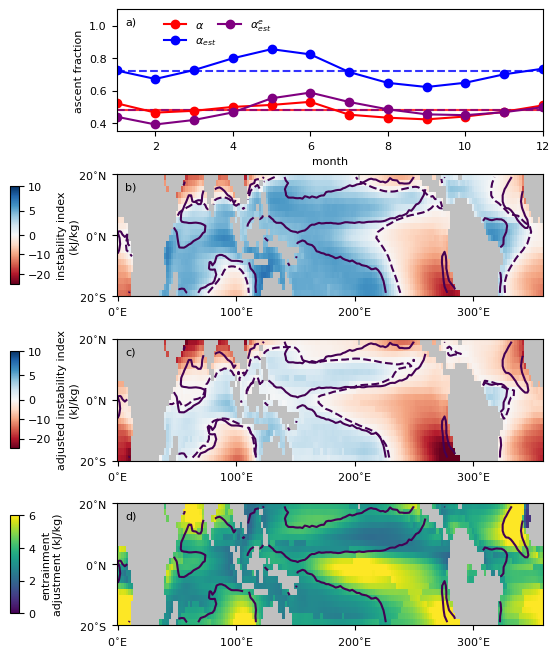

In [14]:
plt.rcParams.update({'font.size': 8})
adjustment_ctrl = np.load('entrainment_adjustments/adjustment_ctrl.npy')
adjustment_ctrl = xr.DataArray(adjustment_ctrl, dims=("month", "lat", "lon"), coords = (months, lat, lon))*units.joule / units.kilogram
ehat = 0.17746965 # taken from 'calc_entrain_adjust.ipynb'

#need to adjust landmask, as some coastal gridpoints have adjustment_ctrl = NaN as they don't have values for 1000hPa
landmask = regionmask.defined_regions.natural_earth_v5_0_0.land_110.mask(ds.lon, lat)
landmask = xr.ones_like(wap500_ctrl).where(landmask.notnull()==False).where(adjustment_ctrl.notnull()==True)
landmask = xr.zeros_like(landmask).where(landmask !=1)

hsfc_ctrl_adjusted = (hsfc_ctrl  - ehat*adjustment_ctrl).where(landmask.notnull()==False)
instability_ctrl_adjusted = (hsfc_ctrl_adjusted -hsat500_ctrl).where(landmask.notnull()==False)
wap500_ctrl = wap500_ctrl.where(landmask.notnull()==False)
instability_ctrl = instability_ctrl.where(landmask.notnull()==False)

#set up axes
fig2 = plt.figure()
a1 = plt.subplot2grid((4, 1), (0, 0))
a1.text(0.02, 0.87, lets[0], transform=a1.transAxes)
a2 = plt.subplot2grid((4, 1), (1, 0)) 
a2.text(0.02, 0.87, lets[1], transform=a2.transAxes)
a3 = plt.subplot2grid((4, 1), (2, 0))
a3.text(0.02, 0.87, lets[2], transform=a3.transAxes)
a4 = plt.subplot2grid((4, 1), (3, 0))
a4.text(0.02, 0.87, lets[3], transform=a4.transAxes)
ax2 = [a1,a2,a3,a4]


# Figure 2 : b- d) maps
month = 2
lat, lon = ta_ctrl.lat, ta_ctrl.lon
n,m =len(lat), len(lon)
divnorm = colors.TwoSlopeNorm(vmin = -25, vcenter = 0, vmax = 10)

ax2[1].pcolormesh(lon, lat, np.ones((n,m)), cmap = 'gist_gray', vmin = -2, vmax = 2)
cs = ax2[1].pcolormesh(lon, lat, instability_ctrl.sel(month = month), norm = divnorm, cmap = 'RdBu')
ax2[1].contour(lon, lat, instability_ctrl.sel(month = month), levels = [0], linestyles = 'dashed')
ax2[1].contour(lon, lat, wap500_ctrl.sel(month = month), levels = [0])
plt.colorbar(cs, ax = ax2[1], cax = ax2[1].inset_axes([-0.25, 0.1, 0.02, 0.8]), ticks = [-20, -10, 0, 5, 10], label = 'instability index\n(kJ/kg)')
ax2[1].set_yticks([-20, 0, 20])
ax2[1].set_yticklabels(['20$^{\circ}$S', '0$^{\circ}$N', '20$^{\circ}$N'])
ax2[1].set_xticks([0, 100, 200, 300])
ax2[1].set_xticklabels(['0$^{\circ}$E', '100$^{\circ}$E', '200$^{\circ}$E', '300$^{\circ}$E'])

ax2[2].pcolormesh(lon, lat, np.ones((n,m)), cmap = 'gist_gray', vmin = -2, vmax = 2)
cs1 = ax2[2].pcolormesh(lon, lat, instability_ctrl_adjusted.sel(month = month), norm = divnorm, cmap = 'RdBu')
ax2[2].contour(lon, lat, instability_ctrl_adjusted.sel(month = month), levels = [0], linestyles = 'dashed')
ax2[2].contour(lon, lat, wap500_ctrl.sel(month = month), levels = [0])
plt.colorbar(cs1, ax = ax2[2], cax = ax2[2].inset_axes([-0.25, 0.1, 0.02, 0.8]), ticks = [-20, -10, 0, 5, 10], label = 'adjusted instability index\n(kJ/kg)')
ax2[2].set_yticks([-20, 0, 20])
ax2[2].set_yticklabels(['20$^{\circ}$S', '0$^{\circ}$N', '20$^{\circ}$N'])
ax2[2].set_xticks([0, 100, 200, 300])
ax2[2].set_xticklabels(['0$^{\circ}$E', '100$^{\circ}$E', '200$^{\circ}$E', '300$^{\circ}$E'])

ax2[3].pcolormesh(lon, lat, np.ones((n,m)), cmap = 'gist_gray', vmin = -2, vmax = 2)
cs2 = ax2[3].pcolormesh(lon, lat, ehat*adjustment_ctrl.sel(month = month)/1000, vmin = 0, vmax = 6)
ax2[3].contour(lon, lat, wap500_ctrl.sel(month = month), levels = [0])
plt.colorbar(cs2, ax = ax2[3], cax = ax2[3].inset_axes([-0.25, 0.1, 0.02, 0.8]), ticks = [0,2,4,6],label = 'entrainment\nadjustment (kJ/kg)') # cax = ax[2].inset_axes([-0.2, 0.2, 0.02, 0.8])
ax2[3].set_yticks([-20, 0, 20])
ax2[3].set_yticklabels(['20$^{\circ}$S', '0$^{\circ}$N', '20$^{\circ}$N'])
ax2[3].set_xticks([0, 100, 200, 300])
ax2[3].set_xticklabels(['0$^{\circ}$E', '100$^{\circ}$E', '200$^{\circ}$E', '300$^{\circ}$E'])

print('alpha up = ' ,float(calc_ascent_frac(wap500_ctrl.sel(month = month), weights, landmask)))
print('original = ', float(proportion_overcome_conv_threshold(hsfc_ctrl.sel(month = month), hsat500_ctrl.sel(month = month),weights, landmask)))
print('adjusted = ',float(proportion_overcome_conv_threshold(hsfc_ctrl_adjusted.sel(month = month), hsat500_ctrl.sel(month = month), weights, landmask)))

# over all 12 months: subplot a)
alpha_up, orig, adjust, int_sat_def = [],[],[], []
all_months = np.arange(1,13,1)
for month in all_months:
    alpha_up = np.append(alpha_up, calc_ascent_frac(wap500_ctrl.sel(month = month), weights, landmask))
    orig = np.append(orig, proportion_overcome_conv_threshold(hsfc_ctrl.sel(month = month), hsat500_ctrl.sel(month = month), weights, landmask))
    adjust = np.append(adjust, proportion_overcome_conv_threshold(hsfc_ctrl_adjusted.sel(month = month), hsat500_ctrl.sel(month = month), weights, landmask))
    int_sat_def = np.append(int_sat_def, (ehat*adjustment_ctrl).sel(month = month).where(landmask.notnull()==False).weighted(weights).mean()/1000)
    

ax2[0].plot([1, 13], [calc_ascent_frac(wap500_ctrl, weights, landmask),calc_ascent_frac(wap500_ctrl, weights, landmask)], '-', color = 'red', alpha = 0.8)
ax2[0].plot([1, 13], [proportion_overcome_conv_threshold(hsfc_ctrl, hsat500_ctrl, weights, landmask),proportion_overcome_conv_threshold(hsfc_ctrl, hsat500_ctrl, weights, landmask)], '--', color = 'blue', alpha = 0.8)
ax2[0].plot([1, 13], [proportion_overcome_conv_threshold(hsfc_ctrl_adjusted, hsat500_ctrl, weights, landmask),proportion_overcome_conv_threshold(hsfc_ctrl_adjusted, hsat500_ctrl, weights, landmask)], '--', color = 'purple', alpha = 0.8)
ax2[0].plot(all_months, alpha_up, 'o-', color = 'red', label = '$\\alpha$')
ax2[0].plot(all_months, orig, 'o-', color = 'blue', label = '$\\alpha_{est}$')
ax2[0].plot(all_months, adjust, 'o-', color = 'purple', label = '$\\alpha_{est}^e$')
ax2[0].legend(ncol = 2,columnspacing=0.2, frameon = False, loc = [0.1, 0.65])
ax2[0].set_xlim([1,12])
ax2[0].set_ylim([0.35, 1.1])
ax2[0].set_ylabel('ascent fraction')
ax2[0].set_xlabel('month')


fig2.subplots_adjust(hspace = 0.35)
fig2.set_size_inches(5.5,8)
fig2.savefig('newplots/Fig2.png', bbox_inches = 'tight', dpi = 300)


In [15]:
#quantifying amplitude change
print('alpha amplitude change')

print(alpha_up.max() - alpha_up.min())
print(orig.max() - orig.min())
print(adjust.max() - adjust.min())


alpha amplitude change
0.10773510184678908
0.23267879815788717
0.19585536837475576
